In [1]:
from congestion_games import *
import matplotlib.pyplot as plt
import itertools
import numpy as np
import copy
import statistics
import seaborn as sns; sns.set()
from time import process_time
from tqdm import tqdm

myp_start = process_time()

def projection_simplex_sort(v, z=1):
	# Courtesy: EdwardRaff/projection_simplex.py
    if v.sum() == z and np.alltrue(v >= 0):
        return v
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

# Define the states and some necessary info
N = 8 #number of agents
harm = - 100 * N # pentalty for being in bad state

safe_state = CongGame(N,1,[[1,0],[2,0],[4,0],[6,0]])
bad_state = CongGame(N,1,[[1,-100],[2,-100],[4,-100],[6,-100]])
state_dic = {0: safe_state, 1: bad_state}

M = safe_state.num_actions 
D = safe_state.m #number facilities
S = 2

# Dictionary to store the action profiles and rewards to
selected_profiles = {}

# Dictionary associating each action (value) to an integer (key)
act_dic = {}
counter = 0
for act in safe_state.actions:
	act_dic[counter] = act 
	counter += 1

def get_next_state(state, actions):
    acts_from_ints = [act_dic[i] for i in actions]
    density = state_dic[state].get_counts(acts_from_ints)
    max_density = max(density)

    if state == 0 and max_density > N/2 or state == 1 and max_density > N/4:
      # if state == 0 and max_density > N/2 and np.random.uniform() > 0.2 or state == 1 and max_density > N/4 and np.random.uniform() > 0.1:
        return 1
    return 0

def pick_action(prob_dist):
    # np.random.choice(range(len(prob_dist)), 1, p = prob_dist)[0]
    acts = [i for i in range(len(prob_dist))]
    action = np.random.choice(acts, 1, p = prob_dist)
    return action[0]

def visit_dist(state, policy, gamma, T,samples):
    # This is the unnormalized visitation distribution. Since we take finite trajectories, the normalization constant is (1-gamma**T)/(1-gamma).
    visit_states = {st: np.zeros(T) for st in range(S)}        
    for i in range(samples):
        curr_state = state
        for t in range(T):
            visit_states[curr_state][t] += 1
            actions = [pick_action(policy[curr_state, i]) for i in range(N)]
            curr_state = get_next_state(curr_state, actions)
    dist = [np.dot(v/samples,gamma**np.arange(T)) for (k,v) in visit_states.items()]
    return dist 

def value_function(policy, gamma, T,samples):
    value_fun = {(s,i):0 for s in range(S) for i in range(N)}
    for k in range(samples):
        for state in range(S):
            curr_state = state
            for t in range(T):
                actions = [pick_action(policy[curr_state, i]) for i in range(N)]
                q = tuple(actions+[curr_state])
                rewards = selected_profiles.setdefault(q,get_reward(state_dic[curr_state], [act_dic[i] for i in actions]))                  
                for i in range(N):
                    value_fun[state,i] += (gamma**t)*rewards[i]
                curr_state = get_next_state(curr_state, actions)
    value_fun.update((x,v/samples) for (x,v) in value_fun.items())
    return value_fun

def Q_function(agent, state, action, policy, gamma, value_fun, samples):
    tot_reward = 0
    for i in range(samples):
        actions = [pick_action(policy[state, i]) for i in range(N)]
        actions[agent] = action
        q = tuple(actions+[state])
        rewards = selected_profiles.setdefault(q,get_reward(state_dic[state], [act_dic[i] for i in actions]))
        tot_reward += rewards[agent] + gamma*value_fun[get_next_state(state, actions), agent]
    return (tot_reward / samples)

def policy_accuracy(policy_pi, policy_star):
    total_dif = N * [0]
    for agent in range(N):
        for state in range(S):
            total_dif[agent] += np.sum(np.abs((policy_pi[state, agent] - policy_star[state, agent])))
	  # total_dif[agent] += np.sqrt(np.sum((policy_pi[state, agent] - policy_star[state, agent])**2))
    return np.sum(total_dif) / N

In [ ]:
def Natural_PG(policy, gradient):
    gradient -= np.mean(gradient)
    new_policy = policy*np.exp(gradient)
    new_policy/=np.sum(new_policy)
    return new_policy
    
# def PG(policy, gradient):
#     gradient -= np.mean(gradient)
#     new_policy = policy+(gradient)
#     # print(new_policy)
#     new_policy = np.maximum(new_policy,0)
#     # print(new_policy)
#     new_policy/=np.sum(new_policy)
#     return new_policy

In [53]:
def NPG_policy_gradient(mu, max_iters, gamma, eta, T, samples):

    policy = {(s,i): [1/M]*M for s in range(S) for i in range(N)}
    policy_hist = [copy.deepcopy(policy)]

    for t in tqdm(range(max_iters)):

        #print(t)

        b_dist = M * [0]
        for st in range(S):
            a_dist = visit_dist(st, policy, gamma, T, samples)

            b_dist[st] = np.dot(a_dist, mu)
            
        grads = np.zeros((N, S, M))
        Q_bar = np.zeros((N, S, M))
        value_fun = value_function(policy, gamma, T, samples)
	
        for agent in range(N):
            for st in range(S):
                for act in range(M):
                    grads[agent, st, act] = b_dist[st] * Q_function(agent, st, act, policy, gamma, value_fun, samples)
                    Q_bar[agent, st, act] =  Q_function(agent, st, act, policy, gamma, value_fun, samples)

        for agent in range(N):
            for st in range(S):
#                 policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * grads[agent,st]), z=1)
#                 policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * Q_bar[agent,st]), z=1)
#                 policy[st, agent] = Natural_PG(policy[st, agent], eta * grads[agent,st])
                policy[st, agent] = Natural_PG(policy[st, agent], eta * Q_bar[agent,st])
        policy_hist.append(copy.deepcopy(policy))

        if policy_accuracy(policy_hist[t], policy_hist[t-1]) < 10e-16:
      # if policy_accuracy(policy_hist[t+1], policy_hist[t]) < 10e-16: (it makes a difference, not when t=0 but from t=1 onwards.)
            return policy_hist

    return policy_hist

def PG_policy_gradient(mu, max_iters, gamma, eta, T, samples):

    policy = {(s,i): [1/M]*M for s in range(S) for i in range(N)}
    policy_hist = [copy.deepcopy(policy)]

    for t in tqdm(range(max_iters)):

        #print(t)

        b_dist = M * [0]
        for st in range(S):
            a_dist = visit_dist(st, policy, gamma, T, samples)

            b_dist[st] = np.dot(a_dist, mu)
            
        grads = np.zeros((N, S, M))
        Q_bar = np.zeros((N, S, M))
        value_fun = value_function(policy, gamma, T, samples)
	
        for agent in range(N):
            for st in range(S):
                for act in range(M):
                    grads[agent, st, act] = b_dist[st] * Q_function(agent, st, act, policy, gamma, value_fun, samples)
                    Q_bar[agent, st, act] =  Q_function(agent, st, act, policy, gamma, value_fun, samples)

        for agent in range(N):
            for st in range(S):
#                 policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * grads[agent,st]), z=1)
                policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * Q_bar[agent,st]), z=1)
#                 policy[st, agent] = Natural_PG(policy[st, agent], eta * grads[agent,st])
#                 policy[st, agent] = Natural_PG(policy[st, agent], eta * Q_bar[agent,st])
        policy_hist.append(copy.deepcopy(policy))

        if policy_accuracy(policy_hist[t], policy_hist[t-1]) < 10e-16:
      # if policy_accuracy(policy_hist[t+1], policy_hist[t]) < 10e-16: (it makes a difference, not when t=0 but from t=1 onwards.)
            return policy_hist

    return policy_hist

def PGA_policy_gradient(mu, max_iters, gamma, eta, T, samples):

    policy = {(s,i): [1/M]*M for s in range(S) for i in range(N)}
    policy_hist = [copy.deepcopy(policy)]

    for t in tqdm(range(max_iters)):

        #print(t)

        b_dist = M * [0]
        for st in range(S):
            a_dist = visit_dist(st, policy, gamma, T, samples)

            b_dist[st] = np.dot(a_dist, mu)
            
        grads = np.zeros((N, S, M))
        Q_bar = np.zeros((N, S, M))
        value_fun = value_function(policy, gamma, T, samples)
	
        for agent in range(N):
            for st in range(S):
                for act in range(M):
                    grads[agent, st, act] = b_dist[st] * Q_function(agent, st, act, policy, gamma, value_fun, samples)
                    Q_bar[agent, st, act] =  Q_function(agent, st, act, policy, gamma, value_fun, samples)

        for agent in range(N):
            for st in range(S):
                policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * grads[agent,st]), z=1)
#                 policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta * Q_bar[agent,st]), z=1)
#                 policy[st, agent] = Natural_PG(policy[st, agent], eta * grads[agent,st])
#                 policy[st, agent] = Natural_PG(policy[st, agent], eta * Q_bar[agent,st])
        policy_hist.append(copy.deepcopy(policy))

        if policy_accuracy(policy_hist[t], policy_hist[t-1]) < 10e-10:
      # if policy_accuracy(policy_hist[t+1], policy_hist[t]) < 10e-16: (it makes a difference, not when t=0 but from t=1 onwards.)
            return policy_hist

    return policy_hist


def get_accuracies(policy_hist):
    fin = policy_hist[-1]
    accuracies = []
    for i in range(len(policy_hist)):
        this_acc = policy_accuracy(policy_hist[i], fin)
        accuracies.append(this_acc)
    return accuracies

In [54]:
def full_experiment(runs,iters,eta,T,samples, algorithm):


    densities = np.zeros((S,M))

    raw_accuracies = []
    for k in (range(runs)):
        if algorithm == "NPG":
            policy_hist = NPG_policy_gradient([0.5, 0.5],iters,0.99,eta,T,samples)
        elif algorithm == "PG":
            policy_hist = PG_policy_gradient([0.5, 0.5],iters,0.99,eta,T,samples)
        elif algorithm == "PGA":
            policy_hist = PGA_policy_gradient([0.5, 0.5],iters,0.99,eta,T,samples)
        else:
            raise NotImplementedError

#         policy_hist = policy_gradient([0.5, 0.5],iters,0.99,eta,T,samples)
        raw_accuracies.append(get_accuracies(policy_hist))

        converged_policy = policy_hist[-1]
        for i in range(N):
            for s in range(S):
                densities[s] += converged_policy[s,i]

    densities = densities / runs

    #densities = densities / runs

    # max_length = 0
    # for j in range(runs):
    #     max_length = max(max_length, len(raw_accuracies[j]))

    # plot_accuracies = np.zeros((runs, max_length))

    # for j in range(runs):
    #     j_len = len(raw_accuracies[j])
    #     plot_accuracies[j][:j_len] = raw_accuracies[j]
    
    plot_accuracies = np.array(list(itertools.zip_longest(*raw_accuracies, fillvalue=np.nan))).T
    clrs = sns.color_palette("husl", 3)
    piters = list(range(plot_accuracies.shape[1]))

    fig2 = plt.figure(figsize=(6,4))
    for i in range(len(plot_accuracies)):
        plt.plot(piters, plot_accuracies[i])
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig2.savefig('individual_runs_n{}.png'.format(N),bbox_inches='tight')
    #plt.close()
    
    plot_accuracies = np.nan_to_num(plot_accuracies)
    if runs==1:
        return plot_accuracies, fig2, _, _
    pmean = list(map(statistics.mean, zip(*plot_accuracies)))
    pstdv = list(map(statistics.stdev, zip(*plot_accuracies)))
    
    fig1 = plt.figure(figsize=(6,4))
    ax = sns.lineplot(piters, pmean, color = clrs[0],label= 'Mean L1-accuracy')
    ax.fill_between(piters, np.subtract(pmean,pstdv), np.add(pmean,pstdv), alpha=0.3, facecolor=clrs[0],label="1-standard deviation")
    ax.legend()
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig1.savefig('avg_runs_n{}.png'.format(N),bbox_inches='tight')
    #plt.close()
    
    #print(densities)

    fig3, ax = plt.subplots()
    index = np.arange(D)
    bar_width = 0.35
    opacity = 1

    #print(len(index))
    #print(len(densities[0]))
    rects1 = plt.bar(index, densities[0], bar_width,
    alpha= .7 * opacity,
    color='b',
    label='Safe state')

    rects2 = plt.bar(index + bar_width, densities[1], bar_width,
    alpha= opacity,
    color='r',
    label='Distancing state')

    plt.gca().set(xlabel='Facility',ylabel='Average number of agents', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N,runs,eta))
    plt.xticks(index + bar_width/2, ('A', 'B', 'C', 'D'))
    plt.legend()
    fig3.savefig('facilities_n{}.png'.format(N),bbox_inches='tight')
   #plt.close()
    plt.show()

    return plot_accuracies, fig1, fig2, fig3

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [01:24<00:00,  2.94it/s]


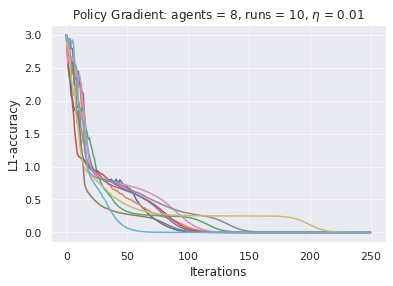

/home/ybsun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


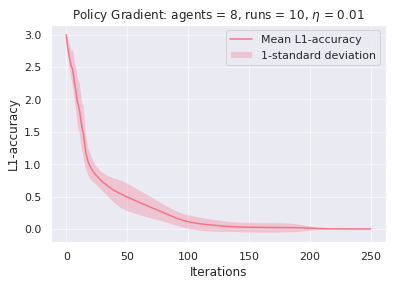

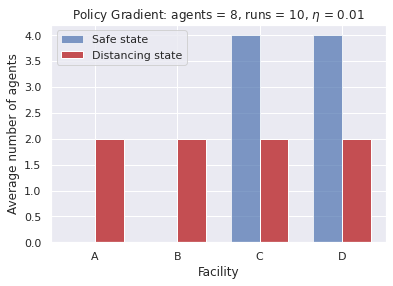

In [61]:
#full_experiment(10,1000,0.0001,20,10)\

runs = 10
max_iters = 250

plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.01,20,10, algorithm="NPG")
np.save("NPG_Proposed_runs", plot_accuracies)

# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.002,20,10, algorithm="PG")
# np.save("PG_Ding_runs", plot_accuracies)

# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.0001,20,10, algorithm="PGA")
# np.save("PGA_Leonardos_runs", plot_accuracies)



# myp_end = process_time()
# elapsed_time = myp_end - myp_start
# print(elapsed_time)

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [01:28<00:00,  2.82it/s]


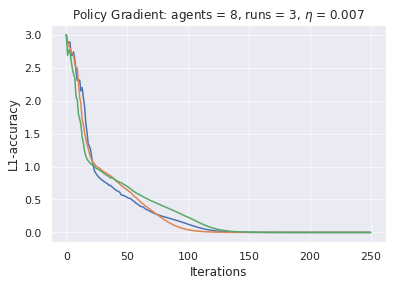

/home/ybsun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


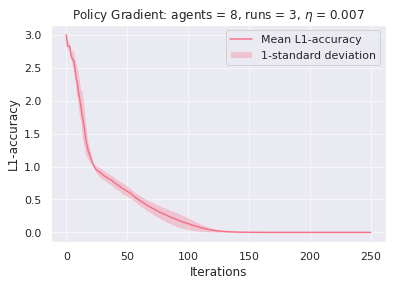

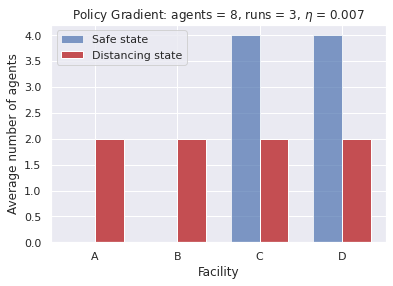

 65%|████████████████████████████████████████████████████▊                            | 163/250 [00:58<00:31,  2.80it/s]


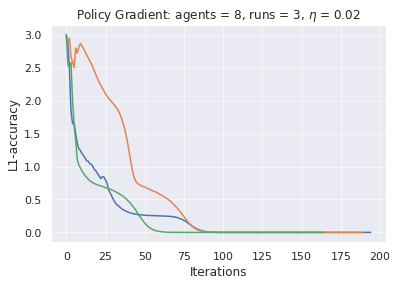

/home/ybsun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


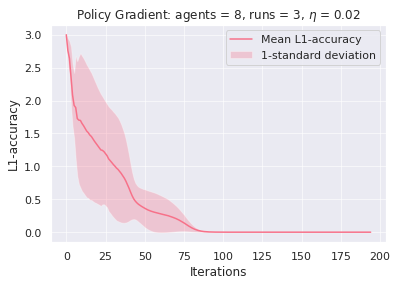

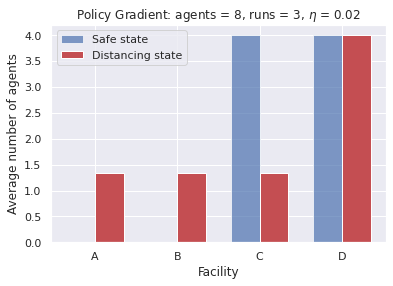

In [60]:
runs = 3
max_iters = 250
# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.0002,20,10, algorithm="NPG")
# np.save("NPG_Proposed_runs_0002", plot_accuracies)
# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.0005,20,10, algorithm="NPG")
# np.save("NPG_Proposed_runs_0005", plot_accuracies)
plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.007,20,10, algorithm="NPG")
np.save("NPG_Proposed_runs_007", plot_accuracies)
# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.002,20,10, algorithm="NPG")
# np.save("NPG_Proposed_runs_002", plot_accuracies)

plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.02,20,10, algorithm="NPG")
np.save("NPG_Proposed_runs_02", plot_accuracies)


# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.002,20,10, algorithm="PG")
# np.save("PG_Ding_runs", plot_accuracies)

# plot_accuracies, _, _, _ = full_experiment(runs,max_iters,0.0001,20,10, algorithm="PGA")
# np.save("PGA_Leonardos_runs", plot_accuracies)

 63%|███████████████████████████████████████████████████▏                             | 158/250 [00:53<00:30,  2.97it/s]


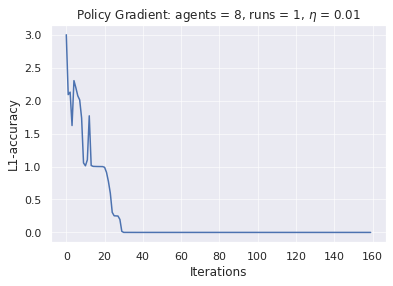

(array([[3.00000000e+00, 2.09155159e+00, 2.12896911e+00, 1.62224884e+00,
         2.30360846e+00, 2.19576357e+00, 2.07352730e+00, 2.01079770e+00,
         1.73612163e+00, 1.05452191e+00, 1.01091407e+00, 1.10146699e+00,
         1.76955585e+00, 1.01614377e+00, 1.00227491e+00, 1.00036604e+00,
         1.00008473e+00, 1.00001962e+00, 9.99901708e-01, 9.98828494e-01,
         9.88017846e-01, 9.12090399e-01, 7.73784846e-01, 5.94923939e-01,
         3.04203274e-01, 2.52480792e-01, 2.50080292e-01, 2.48785104e-01,
         1.96972992e-01, 1.58352561e-02, 3.07403871e-04, 5.60510905e-06,
         1.03457423e-07, 2.97748088e-09, 9.58405816e-10, 7.97292649e-10,
         7.04449777e-10, 6.32077244e-10, 5.71732646e-10, 5.19400738e-10,
         4.72955625e-10, 4.31195733e-10, 3.93380481e-10, 3.59005975e-10,
         3.27695246e-10, 2.99144236e-10, 2.73094754e-10, 2.49320350e-10,
         2.27618813e-10, 2.07807751e-10, 1.89721692e-10, 1.73209957e-10,
         1.58135412e-10, 1.44372824e-10, 1.31807930

In [49]:
#full_experiment(10,1000,0.0001,20,10)
full_experiment(1,250,0.01,20,10,"NPG")

# myp_end = process_time()
# elapsed_time = myp_end - myp_start
# print(elapsed_time)

 80%|████████████████████████████████████████████████████████              | 200/250 [01:13<00:18,  2.71it/s]


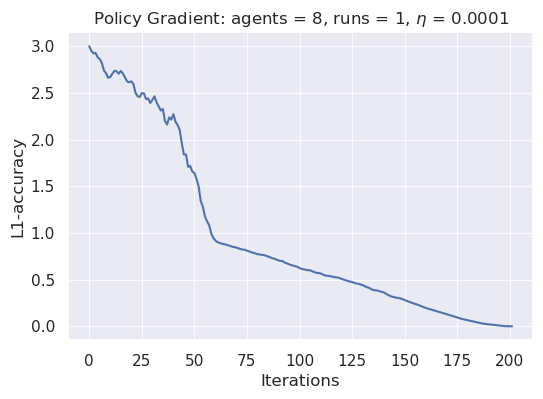

StatisticsError: variance requires at least two data points

In [8]:
#full_experiment(10,1000,0.0001,20,10)
full_experiment(2,250,0.0001,20,10)

myp_end = process_time()
elapsed_time = myp_end - myp_start
print(elapsed_time)